## _*Variational Quantum Classifier*_

The QSVM notebook demonstrates a kernel based approach. This notebook shows a variational method.

For further information please see: [https://arxiv.org/pdf/1804.11326.pdf](https://arxiv.org/pdf/1804.11326.pdf)


**This notebook shows the variational quantum classifier method.**

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import load_iris

from qiskit import transpile
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.passes import Optimize1qGatesDecomposition, CommutativeCancellation
from qiskit.transpiler import PassManager

from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.optimizers import SPSA 

import sys
import os 

# Add local repo root to front of sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, repo_root)  # insert at position 0 to take precedence

# Now import from your local copy
from rivet_transpiler.functions import qml_transpile

/Users/dbharadwaj/anaconda3/envs/rivet/lib/python3.10/site-packages/bqskit/qis/unitary/unitarymatrix.py:412: RuntimeWarning: divide by zero encountered in matmul
  Y = U.conj().T @ U
/Users/dbharadwaj/anaconda3/envs/rivet/lib/python3.10/site-packages/bqskit/qis/unitary/unitarymatrix.py:412: RuntimeWarning: overflow encountered in matmul
  Y = U.conj().T @ U
/Users/dbharadwaj/anaconda3/envs/rivet/lib/python3.10/site-packages/bqskit/qis/unitary/unitarymatrix.py:412: RuntimeWarning: invalid value encountered in matmul
  Y = U.conj().T @ U
/Users/dbharadwaj/anaconda3/envs/rivet/lib/python3.10/site-packages/bqskit/qis/unitary/unitarymatrix.py:411: RuntimeWarning: divide by zero encountered in matmul
  X = U @ U.conj().T
/Users/dbharadwaj/anaconda3/envs/rivet/lib/python3.10/site-packages/bqskit/qis/unitary/unitarymatrix.py:411: RuntimeWarning: overflow encountered in matmul
  X = U @ U.conj().T
/Users/dbharadwaj/anaconda3/envs/rivet/lib/python3.10/site-packages/bqskit/qis/unitary/unitarymatr

First we prepare the dataset, which is used for training, testing and the finally prediction.

In [2]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals


features = MinMaxScaler().fit_transform(features)

train_data, test_data, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


The quantum circuit is made of:
- an encoder (here the ZZFeatureMap is used); x[0] and x[1] are the features of the data point
- a variational form (TwoLocal, probably the simplest there is); the parameters are those learned by the optimizer

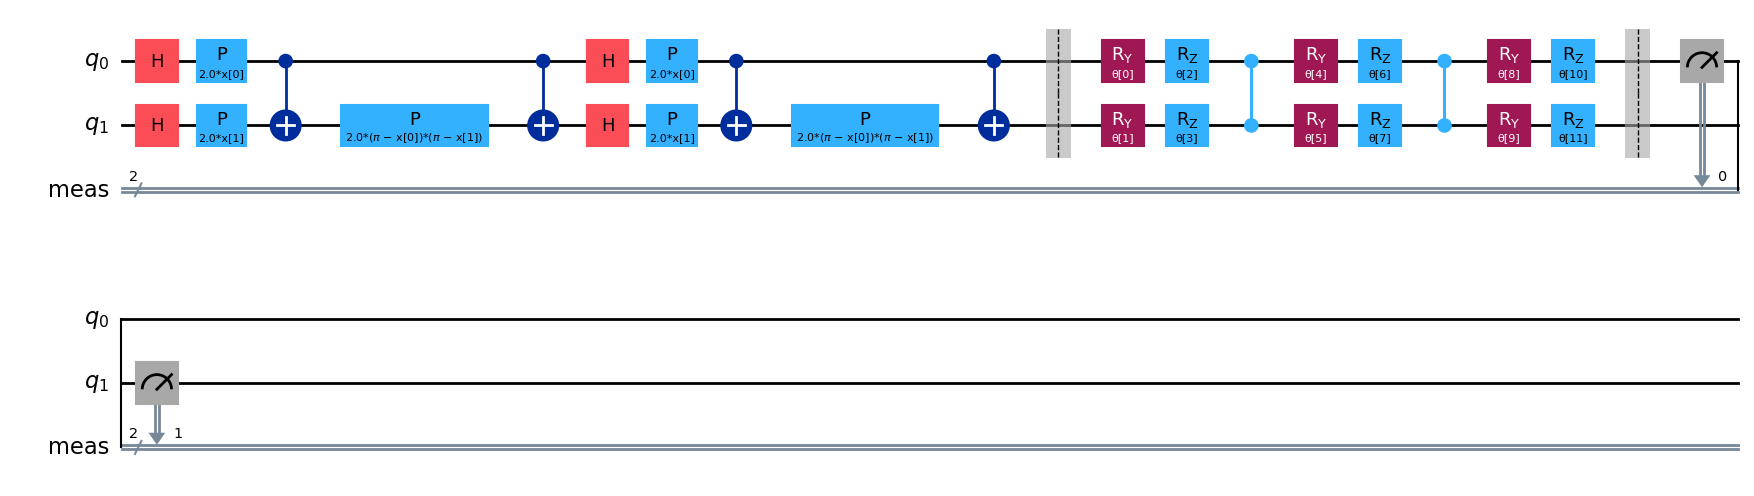

In [3]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
feature_map.barrier()
var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

ad_hoc_circuit = feature_map.compose(var_form)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw(output="mpl", style="iqp")

In [4]:
# Helper to zip parameters
def get_param_dict(data, variational):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return parameters

# 1. Baseline: Transpile unbound circuit once, bind later
transpiled_unbound = transpile(ad_hoc_circuit, basis_gates=['u3', 'cx'])

def circuit_instance_baseline(data, variational):
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = transpiled_unbound.assign_parameters(param_dict)
    elapsed = time.time() - start
    return bound, elapsed

# 2. Upper Bound: Retranspile full circuit for each parameter update
def circuit_instance_upper(data, variational):
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = ad_hoc_circuit.assign_parameters(param_dict)
    transpiled = transpile(bound, basis_gates=['u3', 'cx'])
    elapsed = time.time() - start
    return transpiled, elapsed

def circuit_instance_qml(data, variational):
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = qml_transpile(transpiled_unbound, param_dict)
    elapsed = time.time() - start
    return bound, elapsed

# Example: measure average time for each method over the training set
def measure_strategy(strategy_func, name):
    times = []
    for data, variational in zip(train_data, [np.random.rand(var_form.num_parameters) for _ in train_data]):
        _, elapsed = strategy_func(data, variational)
        times.append(elapsed)
    print(f"{name}: Average time per circuit = {np.mean(times)*1000:.2f} ms")

measure_strategy(circuit_instance_baseline, "Baseline (transpile once, bind later)")
measure_strategy(circuit_instance_upper, "Upper Bound (retranspile each time)")
measure_strategy(circuit_instance_qml, "QML Transpile (bind on transpiled)")

Baseline (transpile once, bind later): Average time per circuit = 0.11 ms
Upper Bound (retranspile each time): Average time per circuit = 3.06 ms
QML Transpile (bind on transpiled): Average time per circuit = 1.23 ms


In [ ]:
# class OptimizerLog:
#     """Log to store optimizer's intermediate results"""
#     def __init__(self):
#         self.evaluations = []
#         self.parameters = []
#         self.costs = []
#     def update(self, evaluation, parameter, cost, _stepsize, _accept):
#         """Save intermediate results. Optimizer passes five values
#         but we ignore the last two."""
#         self.evaluations.append(evaluation)
#         self.parameters.append(parameter)
#         self.costs.append(cost)

In [ ]:
# def test_classifier(data, labels, variational):
#     """Gets classifier's most likely predictions and accuracy of those
#     predictions.

#     Args:
#         data (list): List of data points to classify
#         labels (list): List of correct labels for each data point
#         variational (list): List of parameter values for classifier

#     Returns:
#         float: Average accuracy of classifier over `data`
#         list: Classifier's label predictions for each data point
#     """
#     probability = classification_probability(data, variational)
#     predictions = [0 if p[0] >= p[1] else 1 for p in probability]
#     accuracy = 0

#     for i, prediction in enumerate(predictions):
#         if prediction == labels[i]:
#             accuracy += 1
#     accuracy /= len(labels)
#     return accuracy, predictions

In [7]:
# #  --- GLOBAL TIMING AND DEPTH VARIABLES ---
# baseline_total_time = 0.0
# baseline_calls = 0
# baseline_total_depth = 0

# upper_total_time = 0.0
# upper_calls = 0
# upper_total_depth = 0

# qml_total_time = 0.0
# qml_calls = 0
# qml_total_depth = 0

# # --- CIRCUIT INSTANCE FUNCTIONS WITH TIMING AND DEPTH ---

# def circuit_instance_baseline(data, variational):
#     global baseline_total_time, baseline_calls, baseline_total_depth
#     param_dict = get_param_dict(data, variational)
#     start = time.time()
#     bound = transpiled_unbound.assign_parameters(param_dict)
#     elapsed = time.time() - start
#     baseline_total_time += elapsed
#     baseline_calls += 1
#     baseline_total_depth += bound.depth()
#     return bound, elapsed

# def circuit_instance_upper(data, variational):
#     global upper_total_time, upper_calls, upper_total_depth
#     param_dict = get_param_dict(data, variational)
#     start = time.time()
#     bound = ad_hoc_circuit.assign_parameters(param_dict)
#     transpiled = transpile(bound)
#     elapsed = time.time() - start
#     upper_total_time += elapsed
#     upper_calls += 1
#     upper_total_depth += transpiled.depth()
#     return transpiled, elapsed

# def circuit_instance_qml(data, variational):
#     global qml_total_time, qml_calls, qml_total_depth
#     param_dict = get_param_dict(data, variational)
#     start = time.time()
#     bound = qml_transpile(transpiled_unbound, param_dict)
#     elapsed = time.time() - start
#     qml_total_time += elapsed
#     qml_calls += 1
#     qml_total_depth += bound.depth()
#     return bound, elapsed

# # --- AFTER OPTIMIZATION, PRINT TIMING AND DEPTH STATS ---
# def print_strategy_timings():
#     if baseline_calls > 0:
#         print(f"Baseline: {baseline_calls} calls, total {baseline_total_time:.3f}s, avg {baseline_total_time/baseline_calls*1000:.2f} ms/call, avg depth {baseline_total_depth/baseline_calls:.2f}")
#     if upper_calls > 0:
#         print(f"Upper Bound: {upper_calls} calls, total {upper_total_time:.3f}s, avg {upper_total_time/upper_calls*1000:.2f} ms/call, avg depth {upper_total_depth/upper_calls:.2f}")
#     if qml_calls > 0:
#         print(f"QML Transpile: {qml_calls} calls, total {qml_total_time:.3f}s, avg {qml_total_time/qml_calls*1000:.2f} ms/call, avg depth {qml_total_depth/qml_calls:.2f}")

# # --- STRATEGY SELECTOR ---
# # Choose one: circuit_instance_baseline, circuit_instance_upper, circuit_instance_qml
# CIRCUIT_INSTANCE_FUNC = circuit_instance_baseline
# # CIRCUIT_INSTANCE_FUNC = circuit_instance_upper
# # CIRCUIT_INSTANCE_FUNC = circuit_instance_qml

# # --- UPDATED QML WORKFLOW FUNCTIONS ---

# def classification_probability(data, variational, circuit_instance_func=CIRCUIT_INSTANCE_FUNC):
#     """Classify data points using given parameters and selected circuit instance function."""
#     circuits = [circuit_instance_func(d, variational)[0] for d in data]
#     sampler = StatevectorSampler()
#     results = sampler.run(circuits).result()
#     classification = [
#         label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
#     return classification

# def cost_function(data, labels, variational, circuit_instance_func=CIRCUIT_INSTANCE_FUNC):
#     """Evaluates performance of our circuit with `variational` parameters on `data`."""
#     classifications = classification_probability(data, variational, circuit_instance_func)
#     cost = 0
#     for i, classification in enumerate(classifications):
#         cost += cross_entropy_loss(classification, labels[i])
#     cost /= len(data)
#     return cost

# def objective_function(variational, circuit_instance_func=CIRCUIT_INSTANCE_FUNC):
#     """Cost function of circuit parameters on training data."""
#     return cost_function(train_data, train_labels, variational, circuit_instance_func)


Baseline (transpile once, bind later):
  Avg transpile time: 0.12 ms
  Avg circuit depth: 23.00
  Avg 2-qubit gate count: 8.00


/var/folders/w0/hhmpfx790159l9v9s3ysf69c0000gn/T/ipykernel_48237/384776132.py:3: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  return sum(1 for instr, qargs, cargs in circuit.data if len(qargs) == 2)


Upper Bound (retranspile each time):
  Avg transpile time: 3.22 ms
  Avg circuit depth: 14.00
  Avg 2-qubit gate count: 8.00
QML Transpile (bind on transpiled):
  Avg transpile time: 1.24 ms
  Avg circuit depth: 23.00
  Avg 2-qubit gate count: 8.00


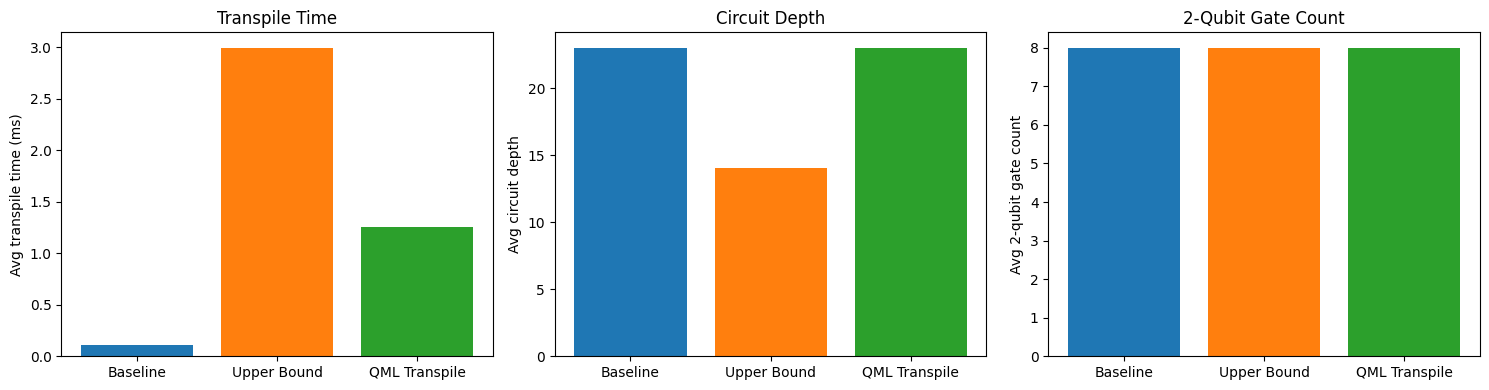

In [8]:
def count_2q_gates(circuit):
    """Count the number of 2-qubit gates in a circuit."""
    return sum(1 for instr, qargs, cargs in circuit.data if len(qargs) == 2)

def benchmark_strategy(strategy_func, name, n_samples=30):
    times = []
    depths = []
    twoq_counts = []
    # Use a subset for speed
    for data, variational in zip(train_data[:n_samples], [np.random.rand(var_form.num_parameters) for _ in range(n_samples)]):
        circ, elapsed = strategy_func(data, variational)
        times.append(elapsed)
        depths.append(circ.depth())
        twoq_counts.append(count_2q_gates(circ))
    print(f"{name}:")
    print(f"  Avg transpile time: {np.mean(times)*1000:.2f} ms")
    print(f"  Avg circuit depth: {np.mean(depths):.2f}")
    print(f"  Avg 2-qubit gate count: {np.mean(twoq_counts):.2f}")

benchmark_strategy(circuit_instance_baseline, "Baseline (transpile once, bind later)")
benchmark_strategy(circuit_instance_upper, "Upper Bound (retranspile each time)")
benchmark_strategy(circuit_instance_qml, "QML Transpile (bind on transpiled)")

labels = ["Baseline", "Upper Bound", "QML Transpile"]
avg_times = [
    np.mean([circuit_instance_baseline(data, np.random.rand(var_form.num_parameters))[1] for data in train_data[:30]]) * 1000,
    np.mean([circuit_instance_upper(data, np.random.rand(var_form.num_parameters))[1] for data in train_data[:30]]) * 1000,
    np.mean([circuit_instance_qml(data, np.random.rand(var_form.num_parameters))[1] for data in train_data[:30]]) * 1000,
]
avg_depths = [
    np.mean([circuit_instance_baseline(data, np.random.rand(var_form.num_parameters))[0].depth() for data in train_data[:30]]),
    np.mean([circuit_instance_upper(data, np.random.rand(var_form.num_parameters))[0].depth() for data in train_data[:30]]),
    np.mean([circuit_instance_qml(data, np.random.rand(var_form.num_parameters))[0].depth() for data in train_data[:30]]),
]
avg_2q = [
    np.mean([count_2q_gates(circuit_instance_baseline(data, np.random.rand(var_form.num_parameters))[0]) for data in train_data[:30]]),
    np.mean([count_2q_gates(circuit_instance_upper(data, np.random.rand(var_form.num_parameters))[0]) for data in train_data[:30]]),
    np.mean([count_2q_gates(circuit_instance_qml(data, np.random.rand(var_form.num_parameters))[0]) for data in train_data[:30]]),
]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar(labels, avg_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axs[0].set_ylabel("Avg transpile time (ms)")
axs[0].set_title("Transpile Time")

axs[1].bar(labels, avg_depths, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axs[1].set_ylabel("Avg circuit depth")
axs[1].set_title("Circuit Depth")

axs[2].bar(labels, avg_2q, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axs[2].set_ylabel("Avg 2-qubit gate count")
axs[2].set_title("2-Qubit Gate Count")

plt.tight_layout()
plt.show()

In [9]:
# ! pip freeze | grep qiskit